In [1]:
using ONNXNaiveNASflux
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances, MLDatasets, CSV, DataFrames
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!

### Loading up our saved models

In [2]:
adv_pgd_strong = ONNXNaiveNASflux.load("../models/adv_pgd_strong.onnx")
adv_pgd_medium = ONNXNaiveNASflux.load("../models/adv_pgd_medium.onnx")
adv_pgd_weak = ONNXNaiveNASflux.load("../models/adv_pgd_weak.onnx")
model = ONNXNaiveNASflux.load("../models/classically_trained.onnx")

CompGraph with graphsummary:
┌────────────────┬───────────┬────────────────┬─────────────────────────┐
│ Graph Position │ Vertex Nr │ Input Vertices │ Op                      │
├────────────────┼───────────┼────────────────┼─────────────────────────┤
│ Input          │ 1         │                │                         │
│ Hidden         │ 2         │ 1              │ Dense(784 => 128, relu) │
│ Output         │ 3         │ 2              │ Dense(128 => 10)        │
└────────────────┴───────────┴────────────────┴─────────────────────────┘


### Loading up our MNIST data

In [3]:
train_df = CSV.read("../data/mnist_train.csv", DataFrame; header=false)
train_data = Matrix(train_df)

test_df = CSV.read("../data/mnist_test.csv", DataFrame; header=false)
test_data = Matrix(test_df)

x_train = train_data[:, 2:785]' ./ 255
y_train = train_data[:, 1]

x_test = test_data[:, 2:785]' ./ 255
y_test = test_data[:, 1]

x_train

784×60000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

### Preparing models for Counterfactual generation

In [4]:
using CounterfactualExplanations

flux_clean = CounterfactualExplanations.MLP(model; likelihood=:classification_multi)
flux_adv_strong = CounterfactualExplanations.MLP(adv_pgd_strong; likelihood=:classification_multi)
flux_adv_medium = CounterfactualExplanations.MLP(adv_pgd_medium; likelihood=:classification_multi) 
flux_adv_weak = CounterfactualExplanations.MLP(adv_pgd_weak; likelihood=:classification_multi)

CounterfactualExplanations.Models.Model(CompGraph(3 vertices), :classification_multi, CounterfactualExplanations.Models.Fitresult(CompGraph(3 vertices), Dict{Any, Any}()), MLP())

### Plot random counterfactuals

In [34]:
counterfactual_data = CounterfactualData(x_train, y_train)
counterfactual_data.domain = [(0, 1) for var in counterfactual_data.features_continuous]
generator = CounterfactualExplanations.ECCoGenerator(; λ=[0.01, 0.1])
# generator = CounterfactualExplanations.GenericGenerator()
convergence = CounterfactualExplanations.GeneratorConditionsConvergence(decision_threshold=0.7, max_iter=1000)

CounterfactualExplanations.Convergence.GeneratorConditionsConvergence(0.7, 0.01, 1000, 0.75)

CounterfactualExplanation
Convergence: ❌ after 1000 steps.
image = [0.00013171235787012847, 0.0, 0.0, 0.0, 3.1564985579279896e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.370944796188269e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7386946274200456e-5, 0.0, 0.0, 1.782004073902499e-6, 2.6061564267365614e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.602945644663123e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00022927632235223428, 0.0, 0.0, 0.01223655502855458, 0.32006712893766337, 0.9922414579272473, 0.2854008451364638, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0797663450575784e-5, 0.0, 0.0, 8.128793429023063e-5, 0.00011356492877894198, 0.00012293086474528538, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001311419462581398, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24597450612119226, 0.9873520979030249, 0.9875034435918398, 0.17161162317215553, 0.0, 0.0, 0.0, 0.0, 0.24783322162095042, 0.0001647147251787

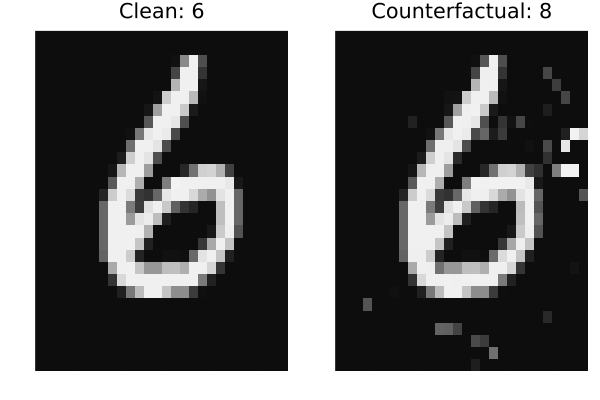

In [40]:
include("../utils/plot.jl")

using CounterfactualExplanations.Evaluation: evaluate, validity

model_to_use = flux_clean
# model_to_use = flux_adv_strong
# model_to_use = flux_adv_medium
# model_to_use = flux_adv_weak

# random point's Counterfactual
index = rand(1:10000)

different_label = rand(0:8)
if different_label >= y_test[index]
    different_label += 1
end
 
ce = generate_counterfactual(
        reshape(x_test[:, index], 784, 1), different_label, counterfactual_data, model_to_use, generator; num_counterfactuals=1, convergence=convergence
    )

println(ce)

ces = CounterfactualExplanations.counterfactual(ce)
cfimage = ces[:, 1]
println("image = ", cfimage)
println("correct_class = ", ce.target)

inf_model = model
# inf_model = adv_pgd_strong
# inf_model = adv_pgd_medium
# inf_model = adv_pgd_weak

cf_pred = (inf_model(cfimage) |> Flux.onecold |> getindex) - 1
println("valid? ", evaluate(ce; measure=validity)[1][1])
actualimage = x_test[:, index]
actual_pred = (inf_model(actualimage) |> Flux.onecold |> getindex) - 1
plot_normal_and_ce(actualimage, actual_pred, cfimage, cf_pred, y_test[index])